In [1]:
import sys
from pathlib import Path

PROJECT_DIR = Path("..").absolute().resolve()
sys.path.append(
    str(PROJECT_DIR)
)  # append a relative path to the top package to the search path


In [2]:
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow_datasets as tfds

from lib.constant import NUTRIMENT_NAMES
from lib.dataset import (
    load_dataset,
    select_feature,
    select_features,
)

2023-01-17 11:33:41.044155: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-17 11:33:41.044169: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/home/raphael/Projects/off-category-classification/.venv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import datasets.off_categories

builder = tfds.builder("off_categories")
builder.download_and_prepare()

Dl Completed...: 100%|██████████| 1/1 [00:00<00:00, 119.79 url/s]
                                                                         

Dataset off_categories downloaded and prepared to /home/raphael/tensorflow_datasets/off_categories/2.0.0. Subsequent calls will reuse this data.


In [4]:
ds = load_dataset("off_categories")["train"]

2023-01-17 11:37:34.859066: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-01-17 11:37:34.859082: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-01-17 11:37:34.859093: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (raphael-NS5x-NS7xPU): /proc/driver/nvidia/version does not exist
2023-01-17 11:37:34.859271: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
def df_item_iter(ds):
    for item in ds:
        output = {
            "code": item["code"].numpy().decode("utf-8"),
            "product_name": item["product_name"].numpy().decode("utf-8") or None,
        }

        for nutriment_field in NUTRIMENT_NAMES:
            output[nutriment_field] = item[nutriment_field].numpy()
        yield output


df = pd.DataFrame(df_item_iter(ds))
ds_size = len(df)

## Product name

In [6]:
df.product_name.describe()

count                           675081
unique                          444658
top       Aceite de oliva virgen extra
freq                              1195
Name: product_name, dtype: object

In [7]:
null_count = len(df[df.product_name.isnull()])
print(f"{null_count} products with empty product names ({null_count*100/ds_size}%)")

5641 products with empty product names (0.8286789614556309%)


## Nutriments

In [8]:
print("# Null value")
for field in NUTRIMENT_NAMES:
    null_count = len(df[df[field] == -1])
    print(f"{field}: {null_count*100/ds_size}% ({null_count})")

print("# Invalid value")
for field in NUTRIMENT_NAMES:
    invalid_count = len(df[df[field] == -2])
    print(f"{field}: {invalid_count*100/ds_size}% ({invalid_count})")

# Null value
fat: 14.862601766947448% (101173)
saturated-fat: 17.595876143271408% (119779)
carbohydrates: 14.958676229062672% (101827)
sugars: 15.835833130117727% (107798)
fiber: 59.515485029130836% (405135)
proteins: 14.878907982994527% (101284)
salt: 17.291346540878656% (117706)
energy-kcal: 19.013782425130962% (129431)
fruits-vegetables-nuts: 98.93759860853623% (673490)
# Invalid value
fat: 0.007198239516278304% (49)
saturated-fat: 0.004407085418129574% (30)
carbohydrates: 0.016600021741621396% (113)
sugars: 0.006904433821736333% (47)
fiber: 0.004407085418129574% (30)
proteins: 0.004847793959942531% (33)
salt: 0.041426602930418% (282)
energy-kcal: 0.005141599654484503% (35)
fruits-vegetables-nuts: 0.0% (0)


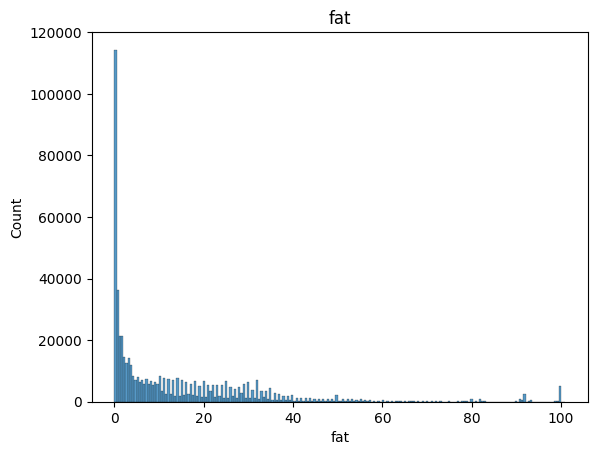

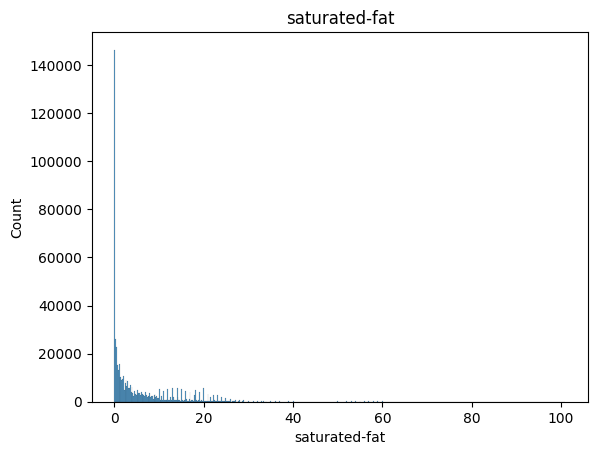

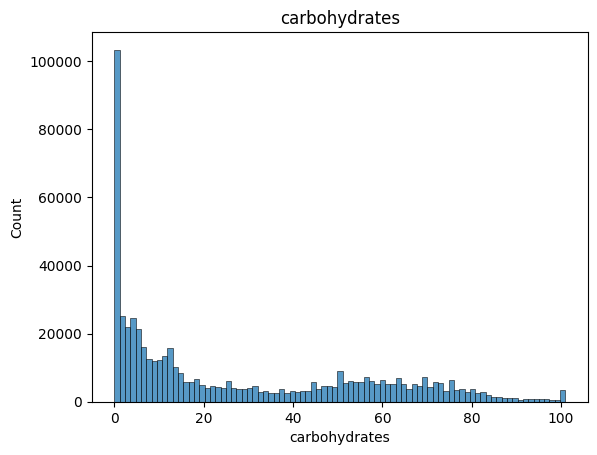

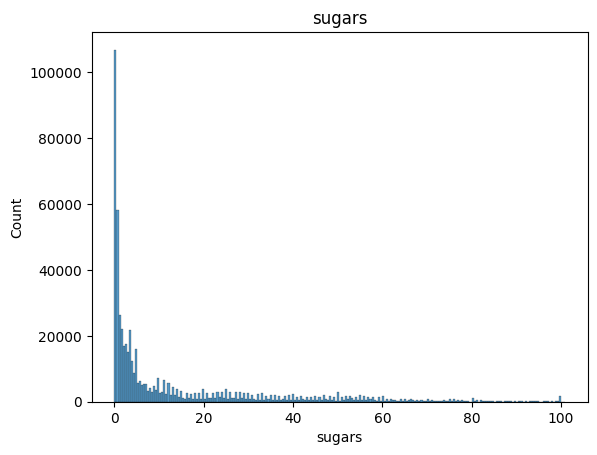

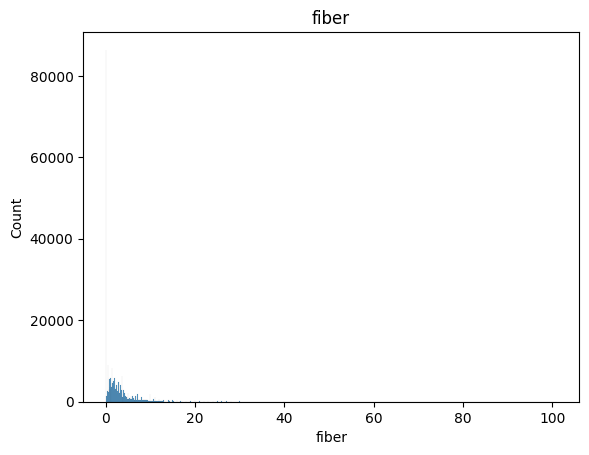

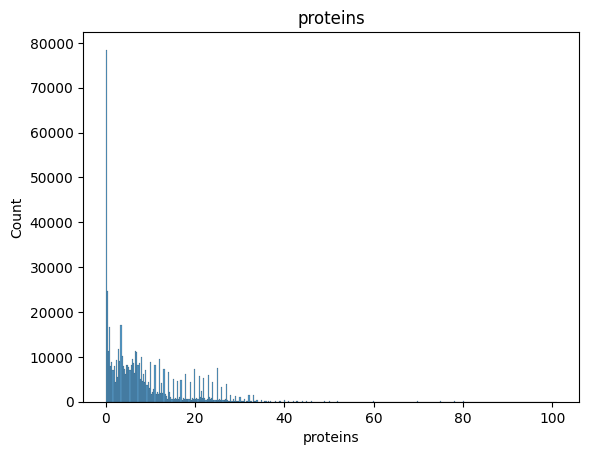

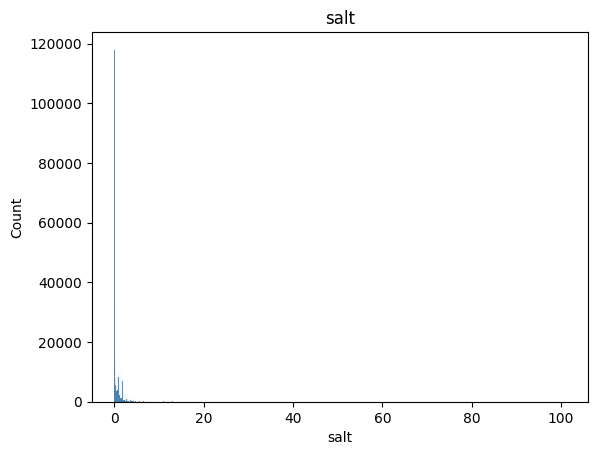

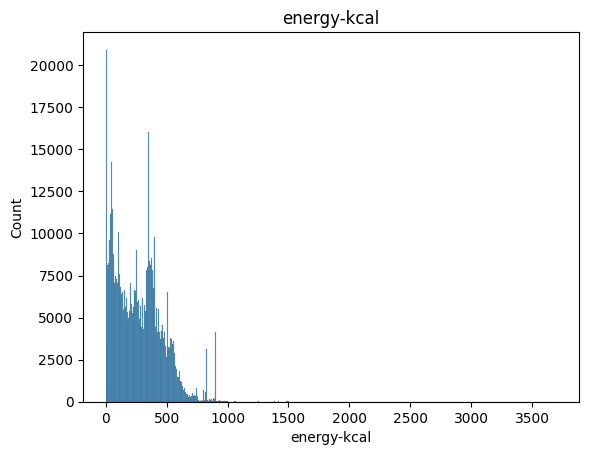

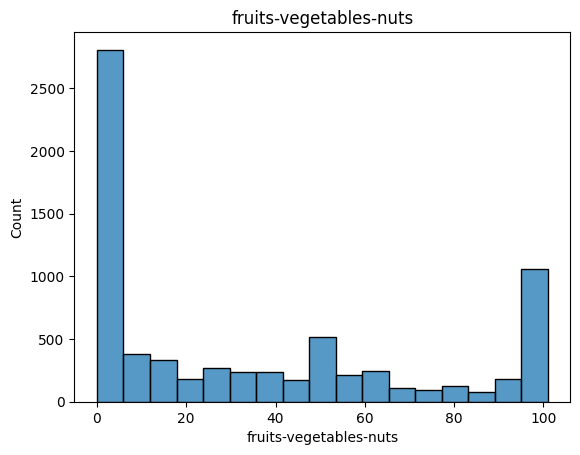

In [9]:
for nutriment_name in NUTRIMENT_NAMES:
    fig, ax = plt.subplots()
    kwargs = {"binrange": (0, 101)} if nutriment_name != "energy-kcal" else {}
    g = sns.histplot(data=df[df[nutriment_name] >= 0], x=nutriment_name, ax=ax, **kwargs)
    ax.set_title(nutriment_name)
    plt.show()

In [10]:
df["energy-kcal"].sort_values(ascending=False)[:20]

425833    3700.000000
181678    3700.000000
188390    3700.000000
75849     3700.000000
450269    3700.000000
186533    3640.000000
465184    3600.000000
680064    3572.000000
486219    3500.000000
448614    3500.000000
427382    3490.000000
300958    3404.000000
215099    3400.000000
430742    3400.000000
340426    3389.000000
105837    3382.000000
402156    3333.333252
77401     3060.000000
275815    2900.000000
319598    2870.000000
Name: energy-kcal, dtype: float32

In [14]:
for field in NUTRIMENT_NAMES:
    bins = np.histogram_bin_edges(df[field], bins="auto", range=(0, df[field].max()))
    print(f"{field=}, {len(bins)} bins, [{bins[0:3]}...{bins[-2:]}")

field='fat', 203 bins, [[0.        0.4950495 0.990099 ]...[ 99.50495 100.     ]
field='saturated-fat', 523 bins, [[0.         0.19157088 0.38314176]...[ 99.808426 100.      ]
field='carbohydrates', 85 bins, [[0.        1.1904762 2.3809524]...[ 98.809525 100.      ]
field='sugars', 220 bins, [[0.       0.456621 0.913242]...[ 99.54338 100.     ]
field='fiber', 931 bins, [[0.         0.10752688 0.21505377]...[ 99.89247 100.     ]
field='proteins', 395 bins, [[0.        0.2538071 0.5076142]...[ 99.74619 100.     ]
field='salt', 3470 bins, [[0.         0.02882675 0.0576535 ]...[ 99.971176 100.      ]
field='energy-kcal', 519 bins, [[ 0.        7.142857 14.285714]...[3692.8572 3700.    ]
field='fruits-vegetables-nuts', 18 bins, [[ 0.        5.882353 11.764706]...[ 94.117645 100.      ]
